# Parameter Inference and Calibration

*Setup from @rmaria del rio-chanona et al. 2021*
*Code: @ebbamark


In [1]:
# Import packages
from abm_funs import *
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyabc.visualization import plot_kde_matrix
import math as math
from pyabc.transition import MultivariateNormalTransition
import seaborn as sns
from IPython.display import display
from PIL import Image
from pstats import SortKey
from matplotlib.backends.backend_pdf import PdfPages
from collate_macro_vars import *
rng = np.random.default_rng()
test_fun()

path = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/"

Function import successful


## Update for Maria

Hi Maria!

The following is the current status of the parameter inference/calibration work using the pyabc package to approach parameter inference/calibration via sequential Monte Carlo approximate Bayesian computation (SMCABC/ABC). I am still running into some snags although I think majority of the obstacles have now been taken care of...I think/hope that the remaining issues or unsatisfactory performance of the calibration is a result of the distance function employed. 

Updates: 

- **Calibrate using SSR of simulated versus real-world vacancy and unemployment rates, scaling by mean and accounting for cyclicality** matching both the mean and oscillation of the real-world UER and vacancy rates. The oscillation of the vacancy rate is still the least well matched. I outline the distance function (distance_weighted()) immediately after the section header "Multiple Paramater Inference" below. For now, we are able to replicate the mean and oscillation of the UER well but only the mean (ie. not oscillation) of the vacancy rate. I have played aronud with a few scaling/normalisation options within the distance function. The distance function now takes both SSR and oscillation into account via a Pearson correlation coefficient, but the weighting of these metrics against each other as well as the variation of the vacancy and unemployment rates still confuse the selection algorithm. I have a hand-selected set of parameters that match the data somewhat better which I use throughout the non-calibration-related work for now but this needs to be improved so that we can systematically select the parameters. The lack of oscillation on the part of the vacancy rate using our calibrated parameters is also why I am unable to replicate the Beveridge curve with the calibrated parameters here too. 
 
#### Summary:

*Question/issues/possible next steps:*
- **Adjusting the distance metric to fix issue outlined above**
- **Suitable ABC rejection conditions:** I don't have a lot of experience with Bayesian methods in general - although this is a fairly intuitive application so I think I've understood most of what is going on. However, the trial-and-error work so far required restricting various parameters of the ABC method (population size/number of accepted simulations, number of iterations in which the acceptance threshold is decreased) to help with implementation. I will need to be more robust in choice of population size and epsilon acceptance threshold once we move toward the "final"/reportable calibration. Any suggestions welcome. 
- **Matching to GDP:** Currently match to a full business cycle between 2006-2017 (most recent full business cycle pre-Covid). As you suggested earlier, might be better to calibrate to the relationship between UER-GDP and vacancy rate-business confidence. See prelim data in Figures 4-6 - GDP will need to be detrended. 
- **Separate gammas into two separate gammas.** For now, the gamma adjustment rate of vacancy and UER are the same. However, separating them might help with the vacancy rate adjustment process. 

Note: All hand-written functions called in the below script are recorded in abm_funs.py to ease reading.


### Data

#### US Model
Model constructed using 464 occupations from US Bureau of Labor Statistics (BLS) Data and IPUMS.
Data input from replication code in dRC et al 2021: https://zenodo.org/records/4453162. This data should be re-extracted. Perhaps incorporate econometric testing for transition probability/matrix calculations.

Additionally includes data on the gender share per occupation also from the BLS.

In [2]:
###################################
# US MODEL CONDITIONS AND DATA ####
###################################

# Set preliminary parameters for delta_u, delta_v, and gamma 
# - these reproduce nice Beveridge curves but were arrived at non-systematically
del_u = 0.029
del_v = 0.025
behav_spec = False
gamma_u = gamma_v = gamma = 0.1
bus_amp = 0.06

A = pd.read_csv(path+"dRC_Replication/data/occupational_mobility_network.csv", header=None)
employment = round(pd.read_csv(path+"dRC_Replication/data/ipums_employment_2016.csv", header = 0).iloc[:, [4]]/10000)
# Crude approximation using avg unemployment rate of ~5% - should aim for occupation-specific unemployment rates
unemployment = round(employment*(0.05/0.95))
# Less crude approximation using avg vacancy rate - should still aim for occupation-specific vacancy rates
vac_rate_base = pd.read_csv(path+"dRC_Replication/data/vacancy_rateDec2000.csv").iloc[:, 2].mean()/100
vacancies = round(employment*vac_rate_base/(1-vac_rate_base))
# Needs input data...
demand_target = employment + vacancies
wages = pd.read_csv(path+"dRC_Replication/data/ipums_variables.csv")[['median_earnings']]
gend_share = pd.read_csv(path+"data/ipums_variables_w_gender.csv")[['women_pct']]
mod_data =  {"A": A, "employment": employment, 
             'unemployment':unemployment, 'vacancies':vacancies, 
             'demand_target': demand_target, 'wages': wages, 'gend_share': gend_share}


### Initialise Network

In [3]:
net_temp, vacs = initialise(len(mod_data['A']), mod_data['employment'].to_numpy(), mod_data['unemployment'].to_numpy(), mod_data['vacancies'].to_numpy(), mod_data['demand_target'].to_numpy(), mod_data['A'], mod_data['wages'].to_numpy(), mod_data['gend_share'].to_numpy(), 0, 3)

## Parameter inference

### Observed Values/Data

Reference values for the various calibration steps are loaded and plotted below for reference. Thus far, I have included variables from the JOLTS (total nonfarm job openings rate, separation rate, quits rate, hires rate - all in seasonally adjusted monthly values). Additionally, I include the seasonally adjusted monthly unemployment rate and quarterly real GDP (although the latter has not been used yet in this script). The job openings, separation, quits, hires rates helped to select the priors for the calibration. 

Recession dates (grey blocks in the below plots) are downloaded from FRED but sourced from NBER business cycle indicators mentioned above. For each time series, I include the source URL. 

#### Separations, Quits, and Hiring Rates

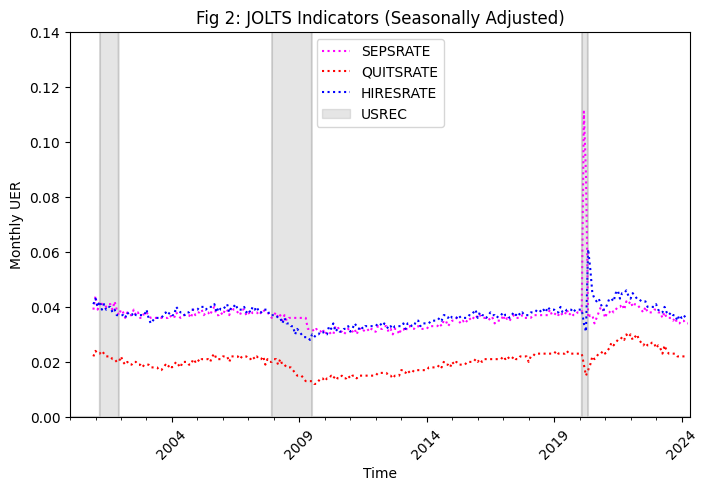

In [4]:

fig, ax = plt.subplots()
jolts.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'SEPSRATE', color = "magenta", linestyle = "dotted")
jolts.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'QUITSRATE', color = "red", linestyle = "dotted")
jolts.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'HIRESRATE', color = "blue", linestyle = "dotted")
recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

plt.xlim("2000-01-01", "2024-05-01")
plt.ylim(0, 0.14)

# Add title and axis labels
plt.title('Fig 2: JOLTS Indicators (Seasonally Adjusted)')
plt.xlabel('Time')
plt.ylabel('Monthly UER')
plt.xticks(rotation=45)

# Display the plot
plt.show()

#### UER, Vacancy Rates, Target Demand, Real GDP

Target demand here is calcualted as employment level + job opening as reported by the BLS/FRED.

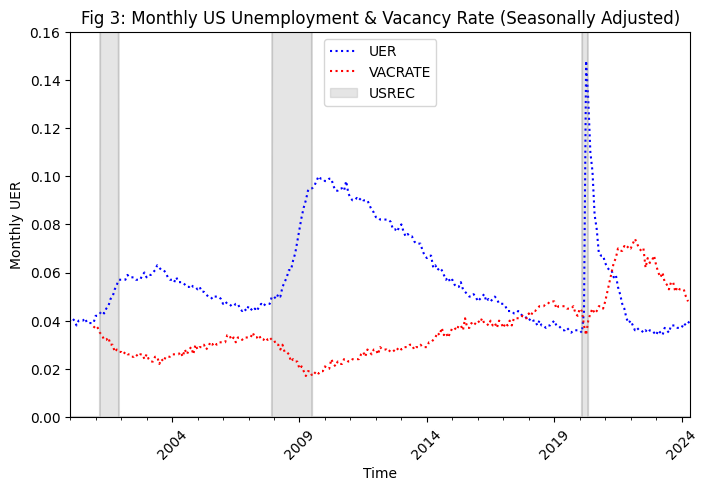

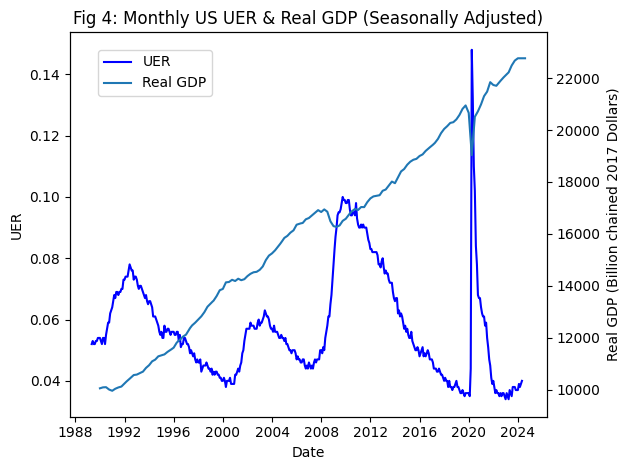

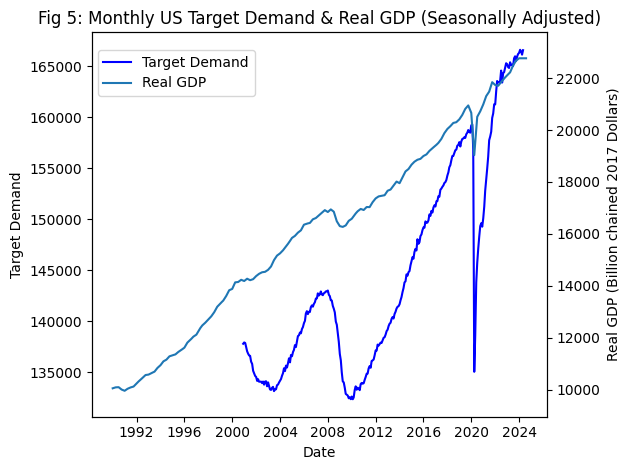

In [5]:
fig, ax = plt.subplots()
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'UER', color = "blue", linestyle = "dotted")
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'VACRATE', color = "red", linestyle = "dotted")
recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

plt.xlim("2000-01-01", "2024-05-01")
plt.ylim(0, 0.16)

# Add title and axis labels
plt.title('Fig 3: Monthly US Unemployment & Vacancy Rate (Seasonally Adjusted)')
plt.xlabel('Time')
plt.ylabel('Monthly UER')
plt.xticks(rotation=45)

# Display the plot
plt.show()


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

### UER AND REAL GDP
ax1.set_xlabel('Date')
ax1.set_ylabel('UER')
ax1.plot(macro_observations['DATE'], macro_observations['UER'], color="blue", label = "UER")
#ax1.set_xlim("2000-01-01", "2024-05-01")
#ax1.area(recessions, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

ax2.set_ylabel('Real GDP (Billion chained 2017 Dollars)')  # we already handled the x-label with ax1
ax2.plot(macro_observations['DATE'], (macro_observations.interpolate())['REALGDP'], label = "Real GDP")
#ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(macro_observations['REALGDP'].min()-1000, macro_observations['REALGDP'].max() + 1000)

fig.legend(bbox_to_anchor=(0.15, 0.9), loc='upper left')
# Add title and axis labels
plt.title('Fig 4: Monthly US UER & Real GDP (Seasonally Adjusted)')
plt.xticks(rotation=45)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

### UER AND REAL GDP
ax1.set_xlabel('Date')
ax1.set_ylabel('Target Demand')
ax1.plot(t_demand_real['DATE'], t_demand_real['TARGET_DEMAND'], color="blue", label = "Target Demand")
#ax1.set_xlim("2000-01-01", "2024-05-01")
#ax1.area(recessions, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

ax2.set_ylabel('Real GDP (Billion chained 2017 Dollars)')  # we already handled the x-label with ax1
ax2.plot(macro_observations['DATE'], (macro_observations.interpolate())['REALGDP'], label = "Real GDP")
#ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(macro_observations['REALGDP'].min()-1000, macro_observations['REALGDP'].max() + 1000)

# Add title and axis labels
fig.legend(bbox_to_anchor=(0.15, 0.9), loc='upper left')
plt.title('Fig 5: Monthly US Target Demand & Real GDP (Seasonally Adjusted)')
plt.xticks(rotation=45)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


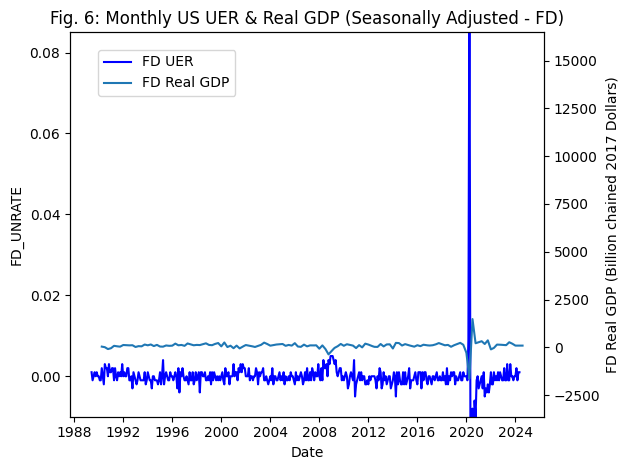

In [6]:
# Using first-differnces 


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

### UER AND REAL GDP
ax1.set_xlabel('Date')
ax1.set_ylabel('FD_UNRATE')
ax1.plot(macro_observations['DATE'], macro_observations['FD_UNRATE'], color="blue", label = "FD UER")
#ax1.set_xlim("2000-01-01", "2024-05-01")
#ax1.area(recessions, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)
ax1.set_ylim(-0.01, 0.085)

ax2.set_ylabel('FD Real GDP (Billion chained 2017 Dollars)')  # we already handled the x-label with ax1
ax2.plot(macro_observations['DATE'], (macro_observations.interpolate())['FD_REALGDP'], label = "FD Real GDP")
#ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(macro_observations['FD_REALGDP'].min()-2000, macro_observations['FD_REALGDP'].max() + 15000)

# Add title and axis labels
fig.legend(bbox_to_anchor=(0.15, 0.9), loc='upper left')
plt.title('Fig. 6: Monthly US UER & Real GDP (Seasonally Adjusted - FD)')
plt.xticks(rotation=45)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



### Multiple Parameter Inference
In the following, I test the joint parameter space of delta_u, delta_v, gamma (same for v and u), and business cycle amplitude (bus_amp). The following code is executed using a remote server. The below displays the results statically. The distance function currently being used is distance_weighted() described in the next code chunk. The below code chunk also shows the chosen priors which were partially informed by the JOLTS indicators outlined above (I will outline this more clearly and explicitly in the Overleaf once calibration is finished). Since running the calibration that produced the below plots, I realised that the upper bound of the prior on the business cycle amplitude might be too low. I am currently re-running this with a prior for bus_amp of: pyabc.RV("uniform", 0.005, 0.1).


In [7]:
run = False
if run:
    # Proposed priors for d_u and d_v taken from the separations and 
    # job openings rates modelled in the first few plots of this notebook
    prior = pyabc.Distribution(d_u = pyabc.RV("uniform", 0.001, 0.05),
                            d_v = pyabc.RV("uniform", 0.001, 0.05),
                            gamma = pyabc.RV("uniform", 0.05, 0.3),
                            bus_amp = pyabc.RV("uniform", 0.005, 0.04))

    # distance function jointly minimises distance between simulated 
    # mean of UER and vacancy rates to real-world UER and vacancy rates
    # Now also matches the shape/oscillation of each variable as an attempt to better match the vacancy rate
    def distance_weighted(x, y, weight_shape=0.5, weight_mean=0.5):
        """
        Weighted distance function combining mean difference and correlation.

        Args:
            x (dict): Simulated data with keys "UER" and "VACRATE".
            y (dict): Real-world data with keys "UER" and "VACRATE".
            weight_shape (float): Weight for shape matching (correlation).
            weight_mean (float): Weight for mean matching (SSE).

        Returns:
            dist (float): Combined distance measure (UER and VACRATE).
        """
        # Calculate sum of squared errors (SSE) for UER and VACRATE
        uer_sse = np.sum(((x["UER"][0:120] - y["UER"]) / np.mean(y["UER"]))**2)
        vacrate_sse = np.sum(((x["VACRATE"][0:120] - y["VACRATE"]) / np.mean(y["VACRATE"]))**2)
        
        # Correlation between simulated and real-world VACRATE (shape matching)
        corr_vacrate = 1 - pearsonr(x["VACRATE"][0:120], y["VACRATE"])[0]
        
        # Correlation between simulated and real-world UER (shape matching)
        corr_uer = 1- pearsonr(x["UER"][0:120], y["UER"])[0]
        
        # Define total distance as weighted sum of mean and shape components
        dist = weight_mean * (np.sqrt(uer_sse) + np.sqrt(vacrate_sse)) + weight_shape * (corr_vacrate + corr_uer)
        return dist

    calib_sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs = 100)
    abc = pyabc.ABCSMC(pyabc_run_single, prior, distance_weighted, population_size = 500, sampler = calib_sampler)

    db_path = os.path.join(tempfile.gettempdir(), "test.db")

    # The following creates the "reference" values from the observed data - I pull the non-recession or expansion period from 2010-2019.
    observation = macro_observations.loc[(macro_observations['DATE'] >= '2006-12-01') & (macro_observations['DATE'] <= "2016-11-01")].reset_index()
    #
    data = {'UER': np.array(observation['UER']),
            'VACRATE': np.array(observation['VACRATE'])}

    abc.new("sqlite:///" + db_path, data)

    history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)


### Preliminary Results
The deltas are fairly well identified with distinct global maximum values. Gamma and business_amp however are difficult to distinguish. As mentioned above, I believe that this might be corrected by increasing the upper bound of the bus_amp prior. Gamma...I am unsure why the behaviour looks the way it does.

For all plots:      
Left = non-behavioural model       
Right = behavioural model

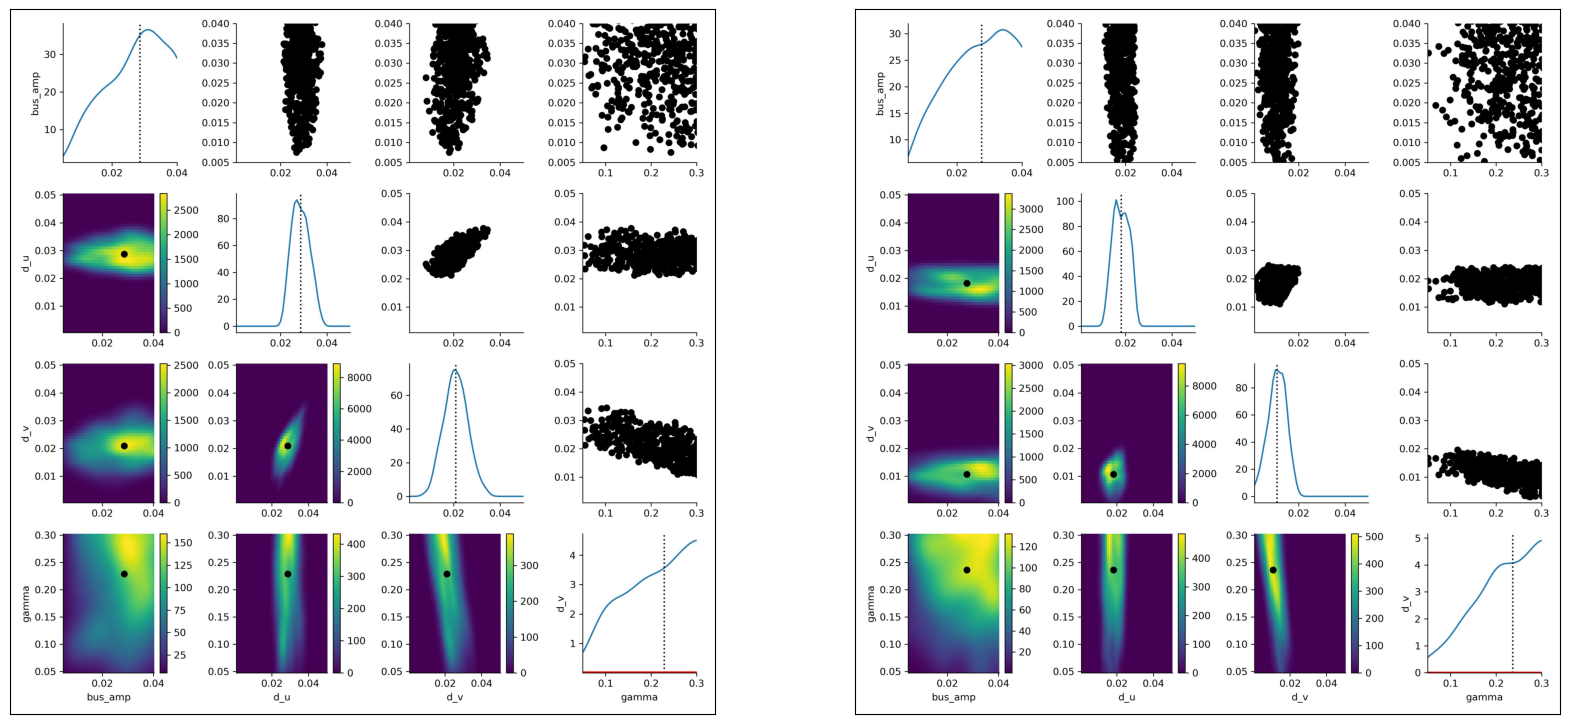

In [8]:
img = mpimg.imread('../calibration/output/kde_plot.jpg')
img_behav = mpimg.imread('../calibration/output/kde_plot_behav.jpg')


# display images
fig, ax = plt.subplots(1,2, figsize=(20, 20))
ax[0].imshow(img)
ax[1].imshow(img_behav)
ax[0].axes.get_xaxis().set_ticks([])
ax[0].axes.get_yaxis().set_ticks([])
ax[1].axes.get_xaxis().set_ticks([])
ax[1].axes.get_yaxis().set_ticks([])
plt.show()

### Heatmaps of the joint parameter space of the deltas

The below two plots show the joint heatmap of the two deltas. The red lines show the weighted posterior maximum for each delta. Not sure if this is the correct way to extract the global max value/triangulate the optimal parameter value...?

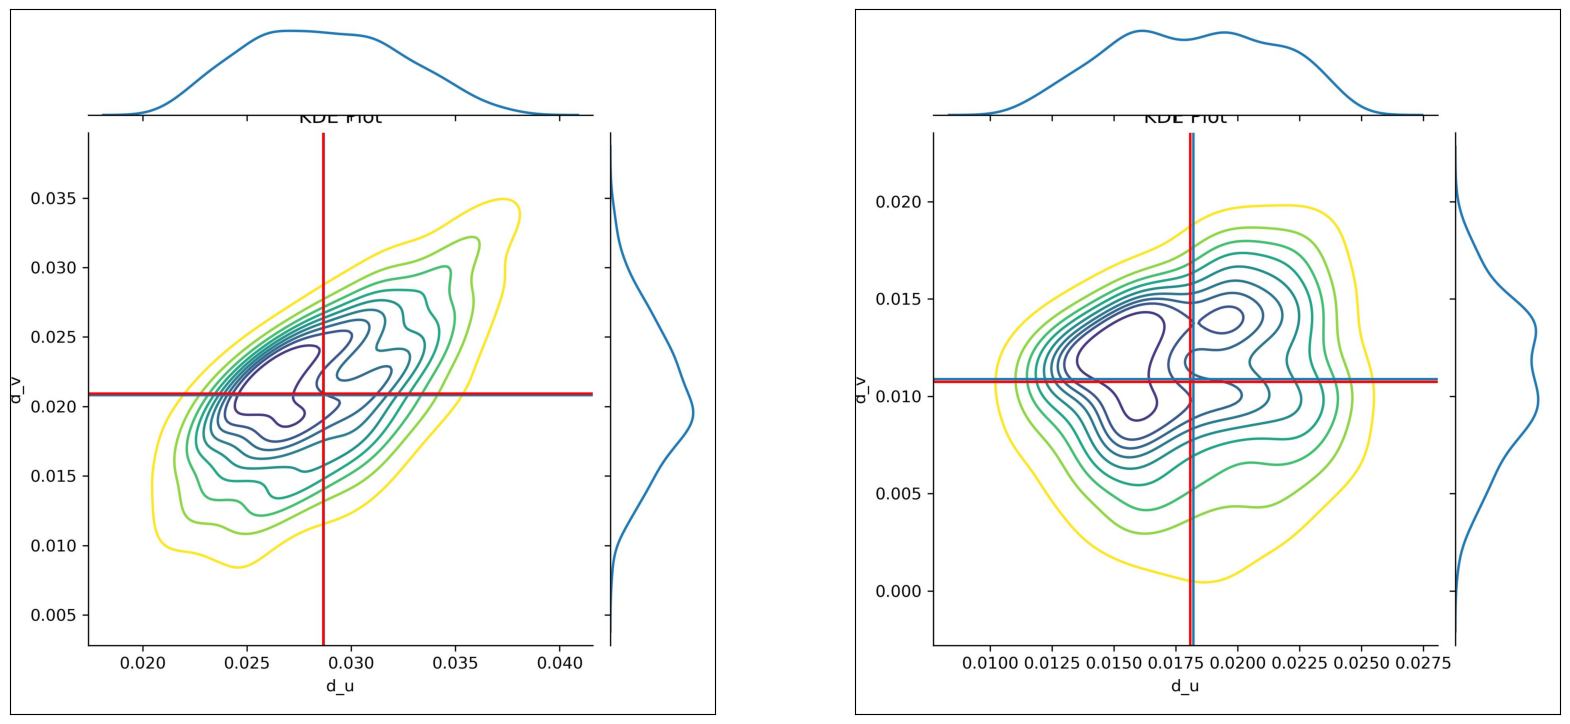

In [9]:
img = mpimg.imread('../calibration/output/joint_plot.jpg')
img_behav = mpimg.imread('../calibration/output/joint_plot_behav.jpg')

# display images
fig, ax = plt.subplots(1,2, figsize=(20, 20))
ax[0].imshow(img)
ax[1].imshow(img_behav)
ax[0].axes.get_xaxis().set_ticks([])
ax[0].axes.get_yaxis().set_ticks([])
ax[1].axes.get_xaxis().set_ticks([])
ax[1].axes.get_yaxis().set_ticks([])
plt.show()

### Comparing models using parameter values sampled from prior, posterior, and selected posterior
The following graphs shows simulation results using parameter combinations sampled from the original prior (worst fit), final posterior (better fit), and accepted parameter combinations from the final posterior distribution which gives the best fit. The black line in each plot represents the real-world for the period 2006-2016. In the bottom plots of the left (non-behavioural model), you can see clearly the issue I mention above regarding the non-fluctuating vacancy rate whereas the behavioural model manages much better. 

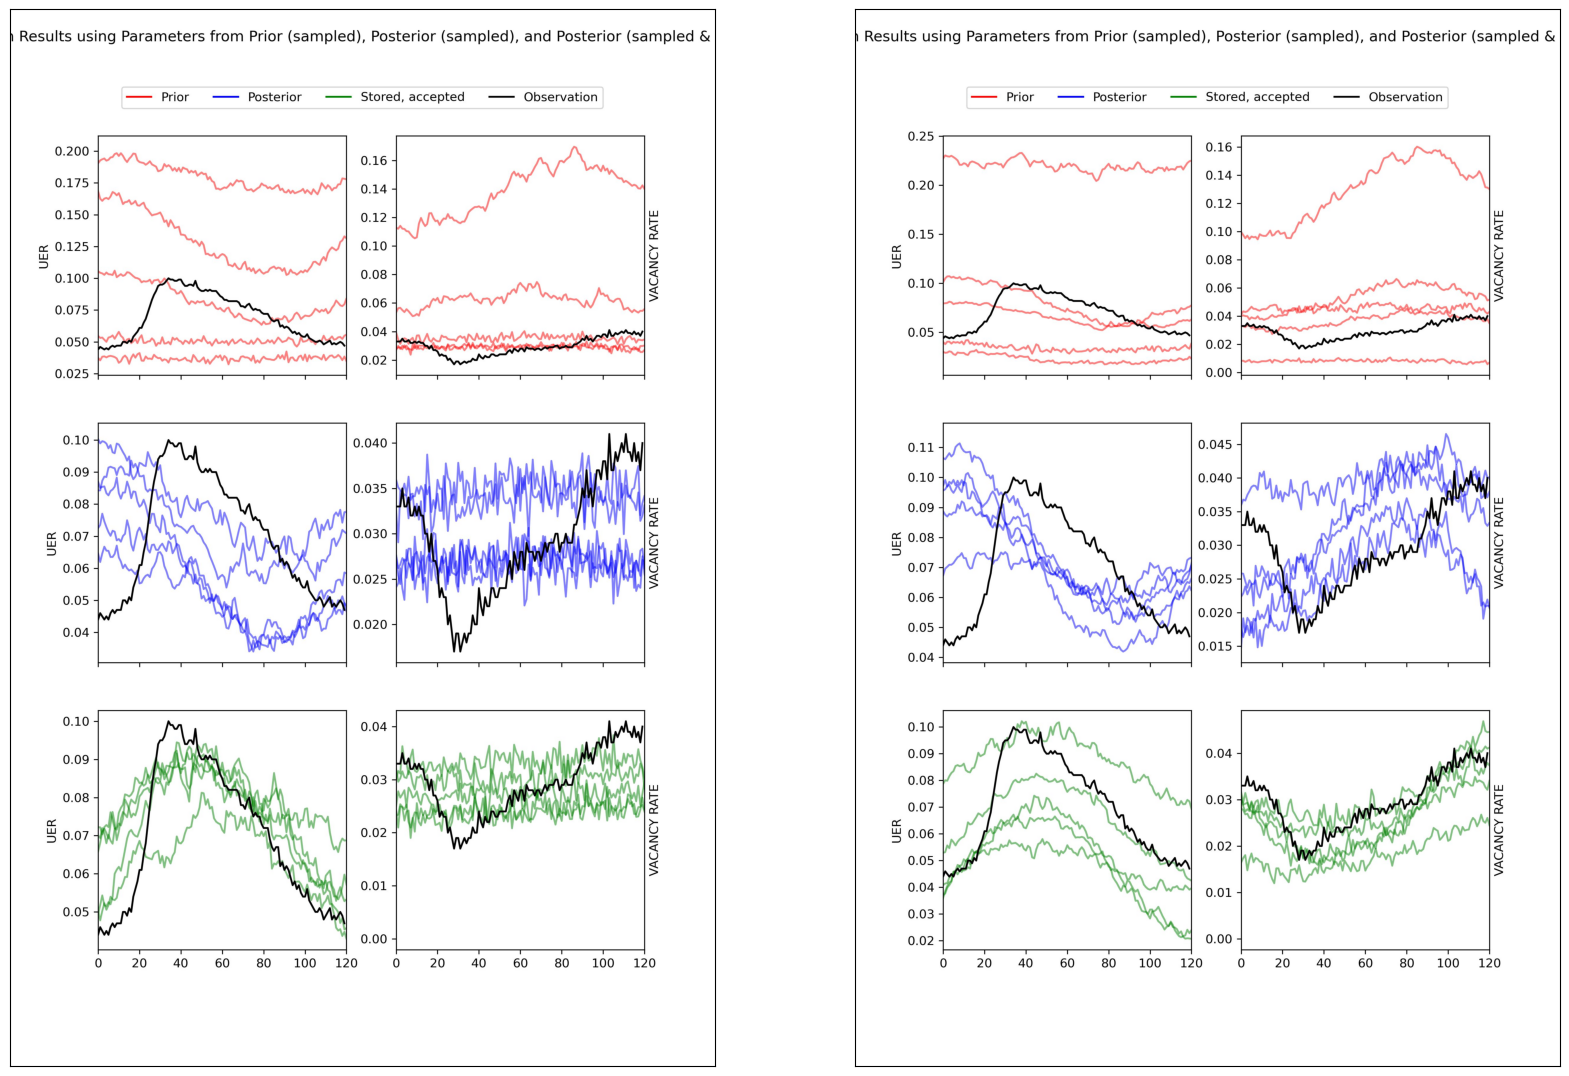

In [10]:
####################################################################################
#### Prior and Posterior Distribution outputs versus Observed UER and Vacancy Rates
img = mpimg.imread('../calibration/output/prior_post_selected_distributions_plot.jpg')
img_behav = mpimg.imread('../calibration/output/prior_post_selected_distributions_plot_behav.jpg')

# display images
fig, ax = plt.subplots(1,2, figsize=(20, 20))
ax[0].imshow(img)
ax[1].imshow(img_behav)
ax[0].axes.get_xaxis().set_ticks([])
ax[0].axes.get_yaxis().set_ticks([])
ax[1].axes.get_xaxis().set_ticks([])
ax[1].axes.get_yaxis().set_ticks([])
plt.show()


### Testing Calibrated Parameters

Below I pull the weighted mean of the posterior for each parameter and feed in as parameters to our model. Again, not sure if this is the correct way to pull the triangulated parameter estimate...? The results for the UER look all right (the symmetry in the UER comes from the sinusoidal business curve - could be improved by calibrating using relationship between UER-GDP). As mentioend above, the vacancy rate is what causes trouble in terms of replication the Beveridge curve - it does not oscillate here and therefore there is no countercyclical relationship between UER and vacancy rate. They grey line shows real-world data on the relationship of UER and vacancy rate from ~2006-2016.

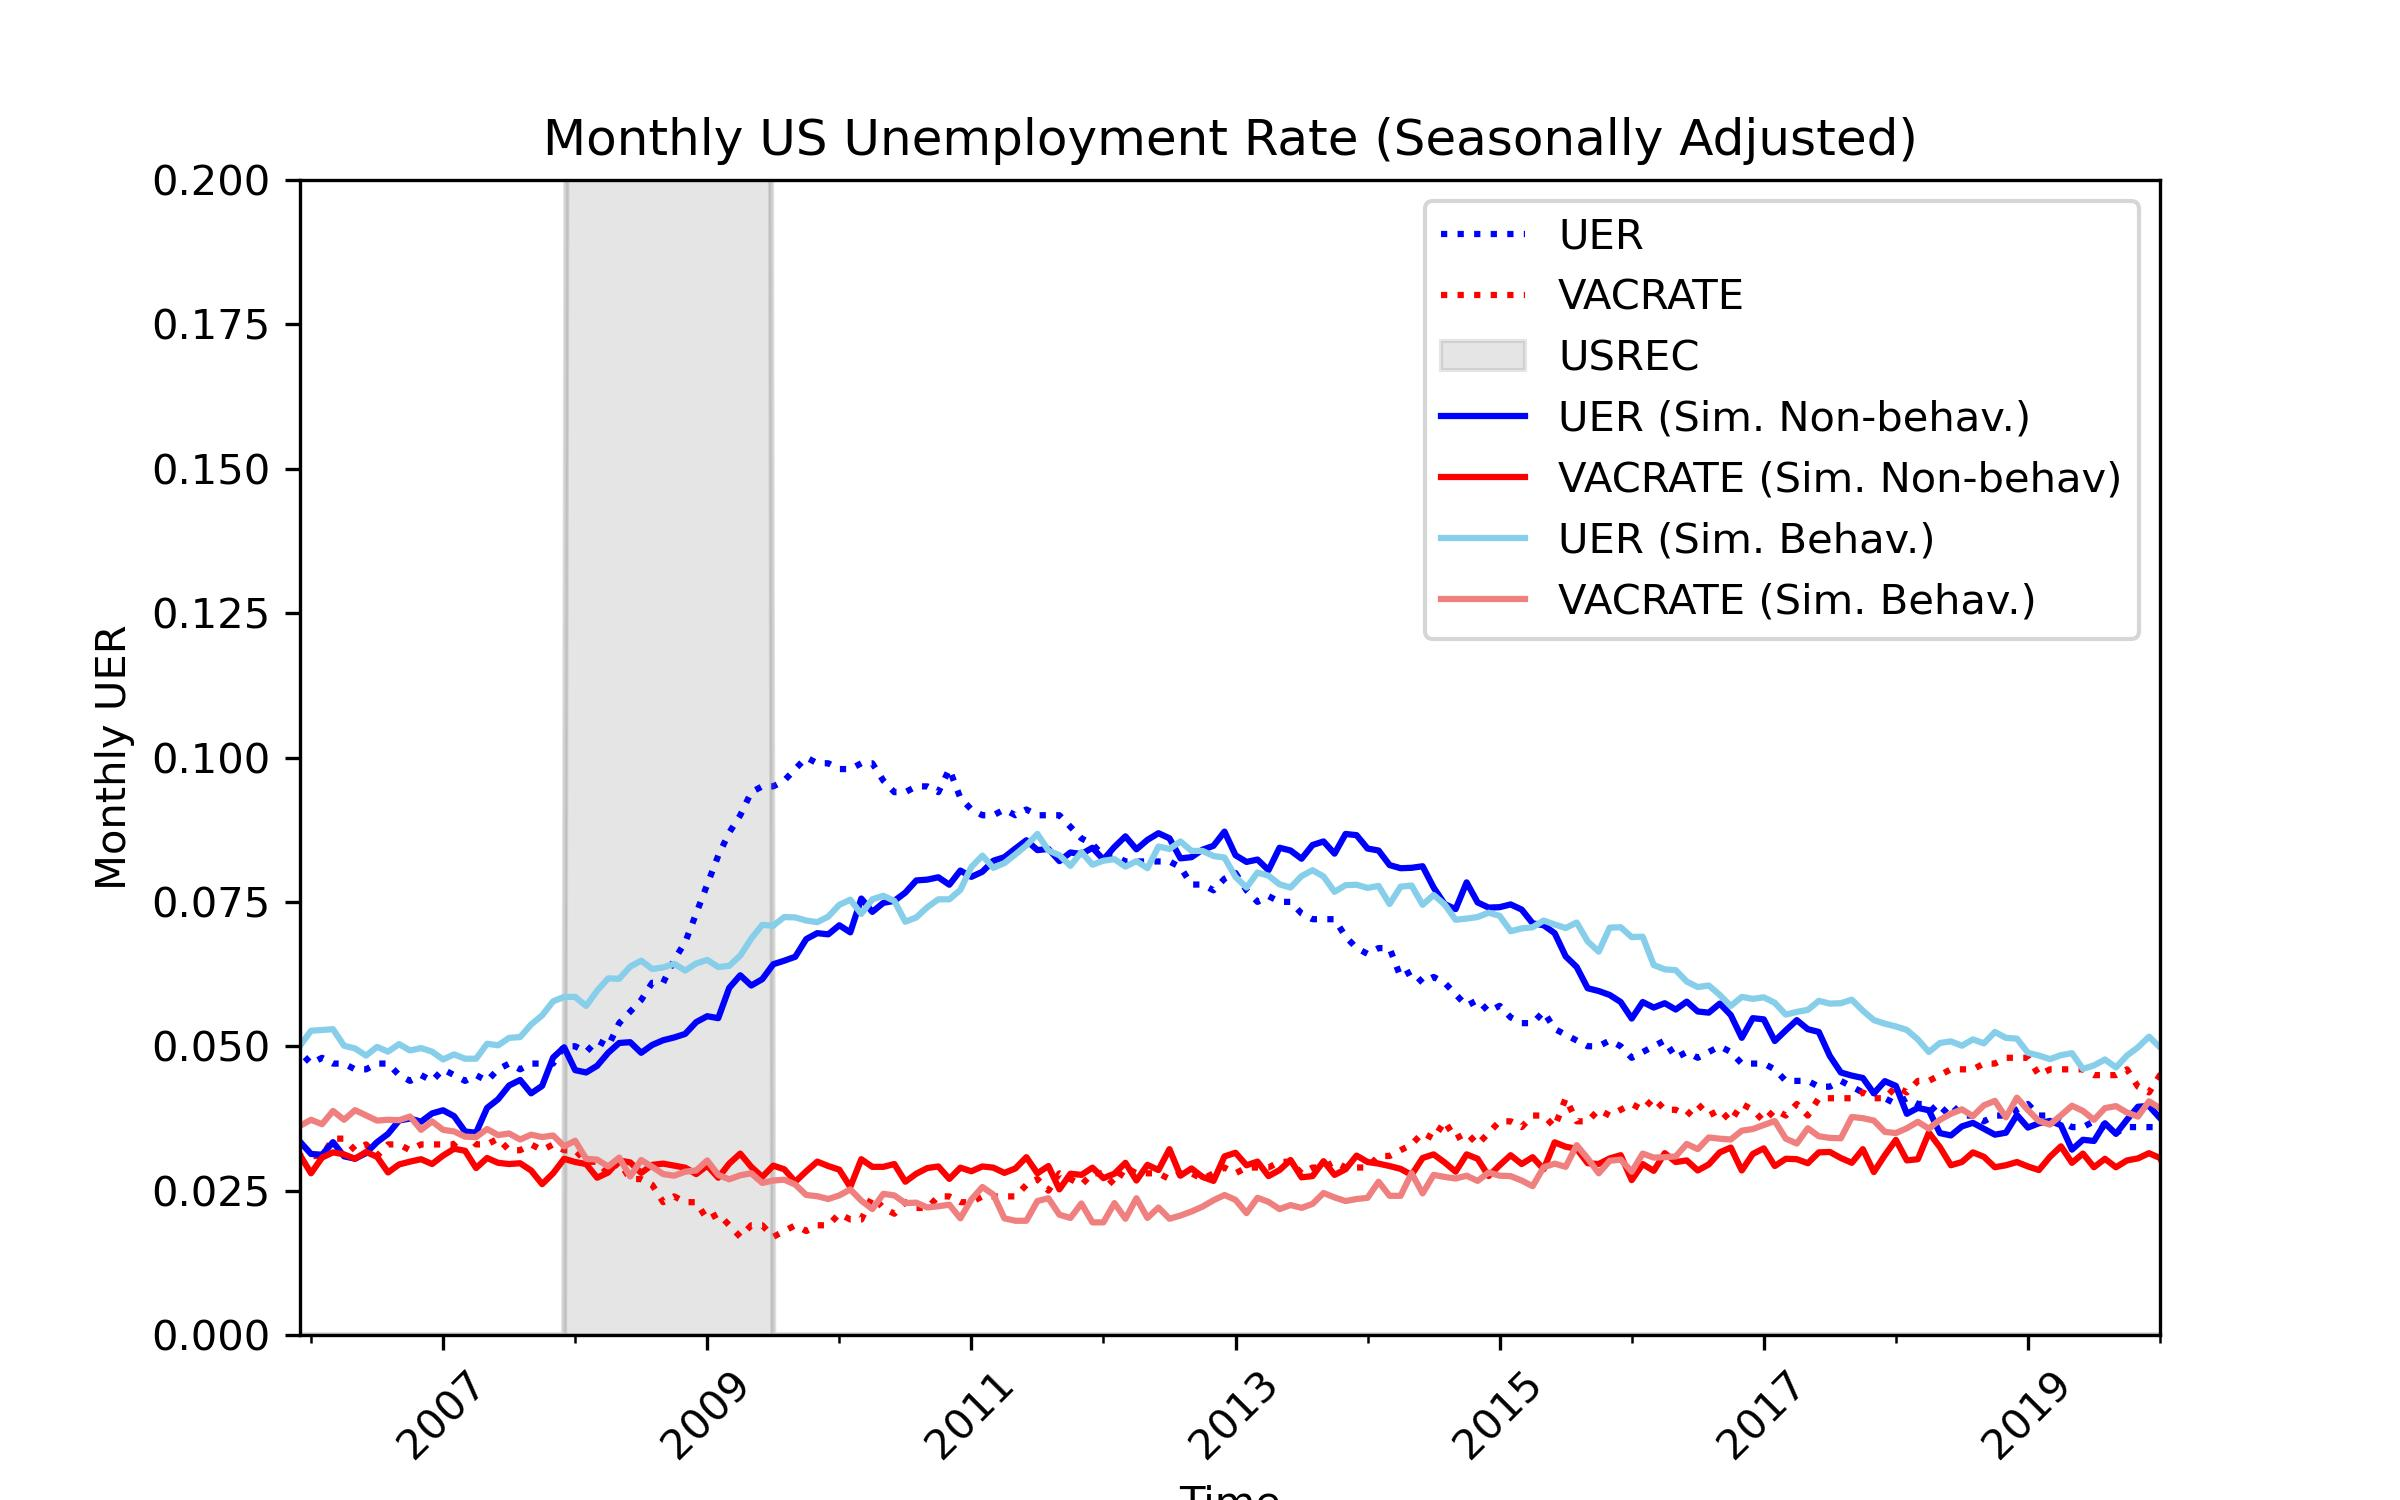

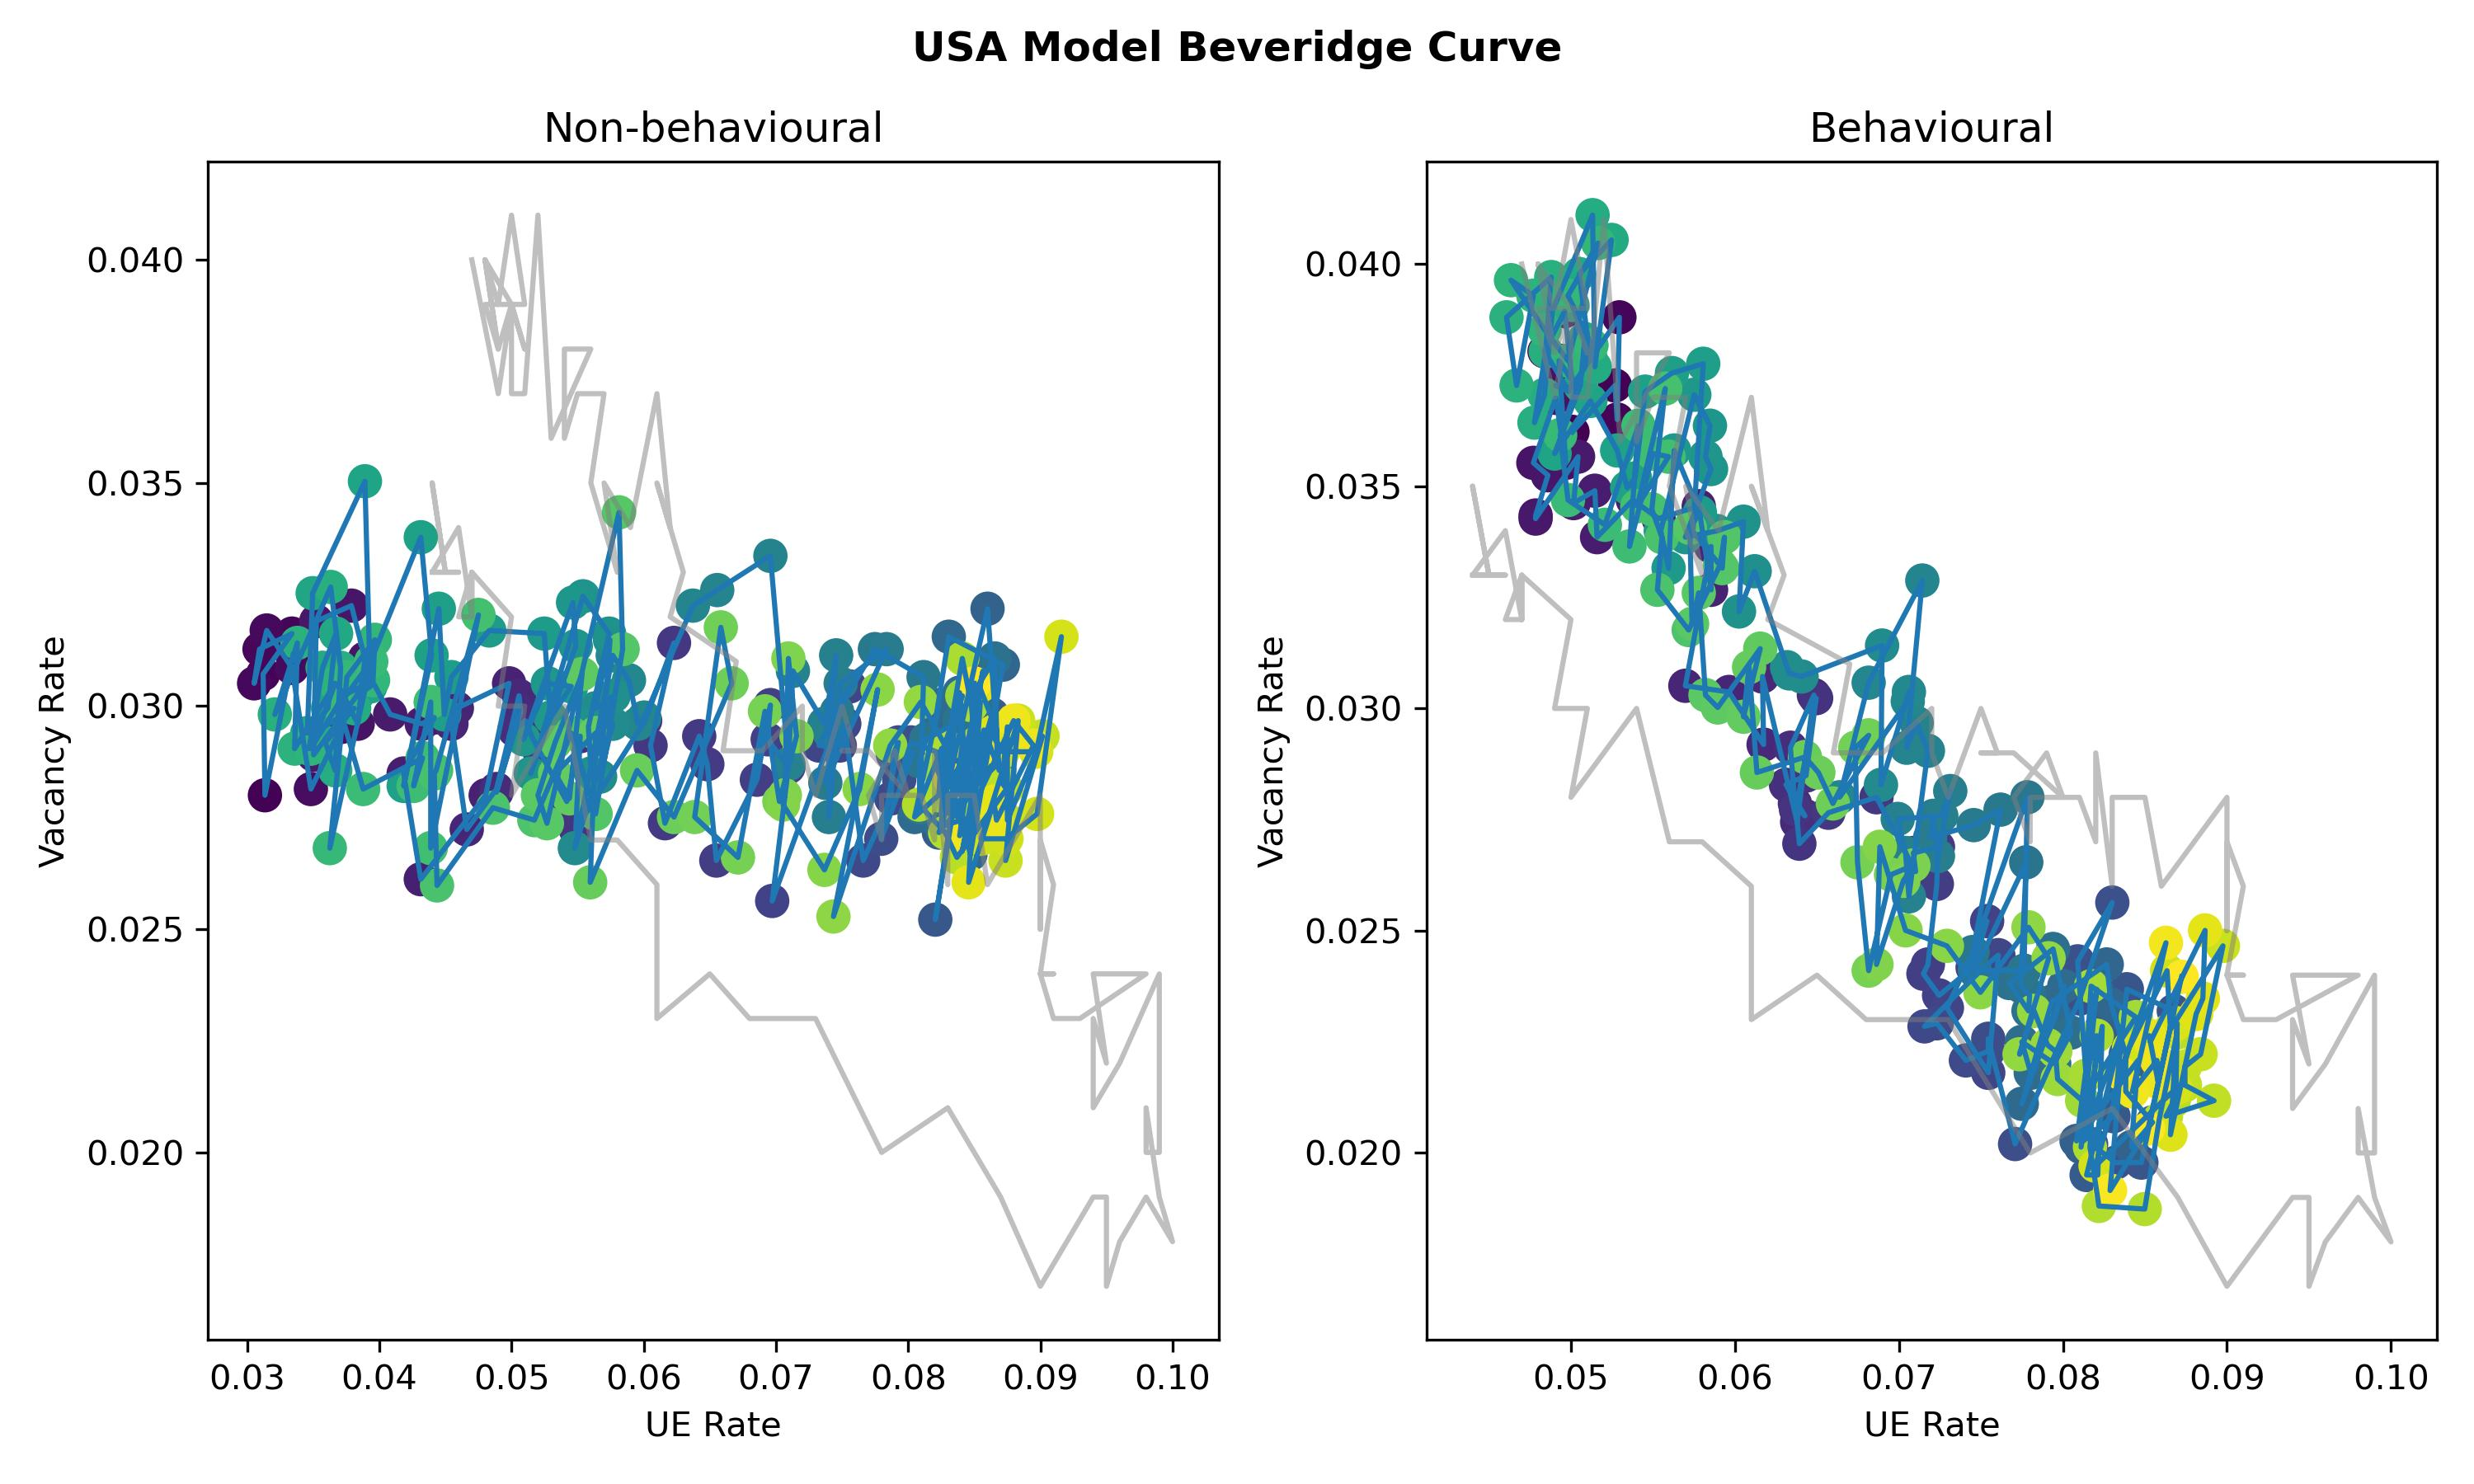

In [11]:
####################################################################################
#### Run with calibrated parameters
img = Image.open('../calibration/output/run_w_calib_params_real_rates.jpg')
display(img)

#####################################################################################
#### Beveridge Curve
img = Image.open('../calibration/output/run_w_calib_params.jpg')
display(img)


## Comparing with Hand-selected Parameters

I provide here the performance of the "hand-selected" parameters that are currently being used in the main model file until they can be replaced by the calibrated parameters, for reference. They perform slightly better....but the calibration is definitely improving. It is mainly the lack of oscillation in the vacancy rate that is the challenge (particularly in the non-behavioural model)...from what I can tell. In the plots immediately below, the dotted lines represnt real-world data and the solid lines represent the model-simulated data where the darker (lighter) red and blue represent the non-behavioural (behavioural) model. Immediately below you see the "Beveridge curve" performance of the models as well. Behavioural performs better than non-behavioural and I cannot quite figure out what causes the major uptick in vacancy rates at low UERs (this behaviour is very sensitive to small changes in the delta_v and gamma parameters).

In [12]:
# The following are the input data to the function that runs the model.

parameter = {'mod_data': mod_data, # mod_data: occupation-level input data (ie. employment/uneployment levels, wages, gender ratio, etc.).
     'net_temp': net_temp, # net_temp: occupational network
     'vacs': vacs, # list of available vacancies in the economy
     'behav_spec': behav_spec, # whether or not to enable behavioural element or not (boolean value)
     'time_steps': 300, # number of time steps to iterate the model - for now always exclude ~50 time steps for the model to reach a steady-state
     'd_u': del_u, # del_u: spontaneous separation rate
     'd_v': del_v, # del_v: spontaneous vacancy rate
     'gamma': gamma, # gamma: "speed" of adjustment to target demand of vacancies and unemployment
     'bus_cycle_len': 160, # bus_cycle_len: length of typical business cycle (160 months as explained above)
     'bus_amp': bus_amp,
     'delay': 80} # delay: number of time steps to exclude from calibration sample to allow model to reach steady state and expansion phase of business cycle - this is certainly inefficient and should be changed.


# The following line runs one base example of the model itself with the hand-picked parameters outlined above. 
# Run model without behavioural spec
rec = run_single_local(**parameter)

parameter.update({'behav_spec': True,
                   'd_u': 0.016,
                   'd_v': 0.01,
                   'gamma': 0.13,
                   'bus_amp': 0.05})

rec_behav = run_single_local(**parameter)


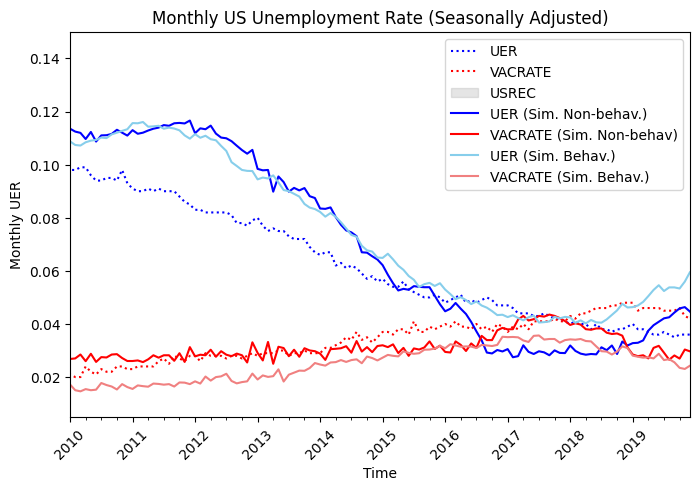

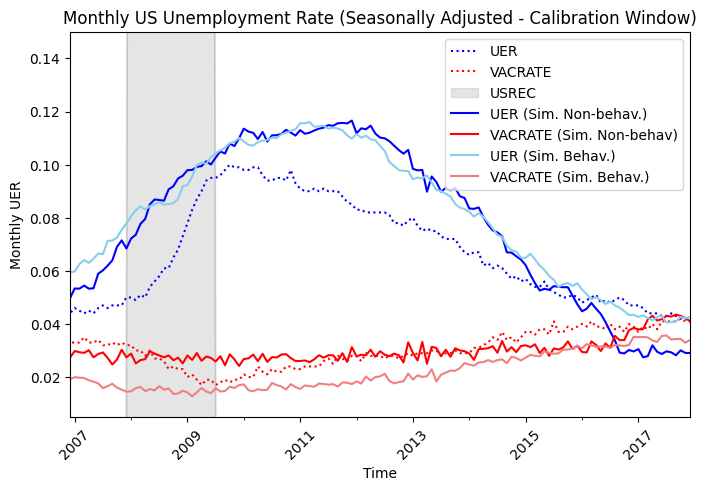

In [13]:

# Incorporating one set of simulated data
sim_data = pd.DataFrame(rec)
sim_data['PROV DATE'] = pd.date_range(start = "2006-12-01", periods = len(sim_data), freq = "ME")
sim_data['FD_SIMUER'] = pd.Series(sim_data['UER']).diff()
sim_data['FD_SIMVACRATE'] = pd.Series(sim_data['VACRATE']).diff()

sim_data_behav = pd.DataFrame(rec_behav)
sim_data_behav['PROV DATE'] = pd.date_range(start = "2006-12-01", periods = len(sim_data_behav), freq = "ME")
sim_data_behav['FD_SIMUER'] = pd.Series(sim_data_behav['UER']).diff()
sim_data_behav['FD_SIMVACRATE'] = pd.Series(sim_data_behav['VACRATE']).diff()

# Non-recession period
fig, ax = plt.subplots()
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'UER', color = "blue", linestyle = "dotted")
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'VACRATE', color = "red", linestyle = "dotted")
recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)
sim_data.plot.line(ax = ax, x = 'PROV DATE', y = 'UER', color = "blue", label = "UER (Sim. Non-behav.)")
sim_data.plot.line(ax = ax, x = 'PROV DATE', y = 'VACRATE', color = "red", label = "VACRATE (Sim. Non-behav)")
sim_data_behav.plot.line(ax = ax, x = 'PROV DATE', y = 'UER', color = "skyblue", label = "UER (Sim. Behav.)")
sim_data_behav.plot.line(ax = ax, x = 'PROV DATE', y = 'VACRATE', color = "lightcoral", label = "VACRATE (Sim. Behav.)")

plt.xlim("2010-01-01", "2019-12-01")
plt.ylim(0.005, 0.15)

# Add title and axis labels
plt.title('Monthly US Unemployment Rate (Seasonally Adjusted)')
plt.xlabel('Time')
plt.ylabel('Monthly UER')
plt.xticks(rotation=45)

# Display the plot
plt.show()

# Incorporating one set of simulated data
sim_data = pd.DataFrame(rec)
sim_data['PROV DATE'] = pd.date_range(start = "2006-12-01", periods = len(sim_data), freq = "ME")
sim_data['FD_SIMUER'] = pd.Series(sim_data['UER']).diff()
sim_data['FD_SIMVACRATE'] = pd.Series(sim_data['VACRATE']).diff()

sim_data_behav = pd.DataFrame(rec_behav)
sim_data_behav['PROV DATE'] = pd.date_range(start = "2006-12-01", periods = len(sim_data_behav), freq = "ME")
sim_data_behav['FD_SIMUER'] = pd.Series(sim_data_behav['UER']).diff()
sim_data_behav['FD_SIMVACRATE'] = pd.Series(sim_data_behav['VACRATE']).diff()

# Non-recession period
fig, ax = plt.subplots()
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'UER', color = "blue", linestyle = "dotted")
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'VACRATE', color = "red", linestyle = "dotted")
recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)
sim_data.plot.line(ax = ax, x = 'PROV DATE', y = 'UER', color = "blue", label = "UER (Sim. Non-behav.)")
sim_data.plot.line(ax = ax, x = 'PROV DATE', y = 'VACRATE', color = "red", label = "VACRATE (Sim. Non-behav)")
sim_data_behav.plot.line(ax = ax, x = 'PROV DATE', y = 'UER', color = "skyblue", label = "UER (Sim. Behav.)")
sim_data_behav.plot.line(ax = ax, x = 'PROV DATE', y = 'VACRATE', color = "lightcoral", label = "VACRATE (Sim. Behav.)")

plt.xlim("2006-12-01", "2017-12-01")
plt.ylim(0.005, 0.15)

# Add title and axis labels
plt.title('Monthly US Unemployment Rate (Seasonally Adjusted - Calibration Window)')
plt.xlabel('Time')
plt.ylabel('Monthly UER')
plt.xticks(rotation=45)

# Display the plot
plt.show()



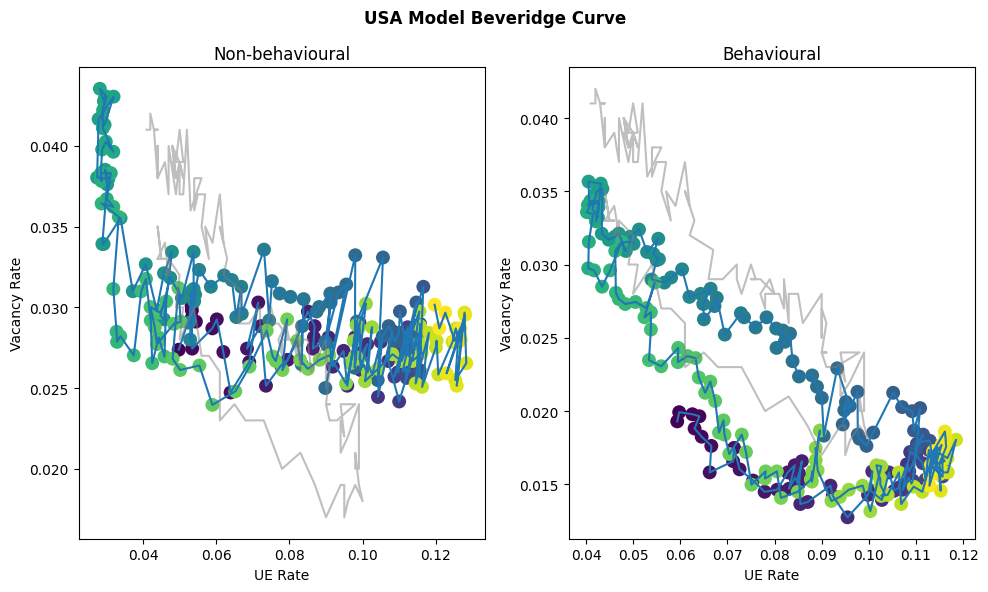

In [14]:
macro_abbrev = macro_observations.loc[(macro_observations['DATE'] >= "2006-12-01") & (macro_observations['DATE'] <= "2017-12-01")].reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.plot(sim_data['UER'], sim_data['VACRATE'])
ax1.scatter(sim_data['UER'], sim_data['VACRATE'], c=sim_data.index, s=100, lw=0)
ax1.plot(macro_abbrev['UER'], macro_abbrev['VACRATE'], c = "grey", alpha = 0.5)
ax1.set_title("Non-behavioural")
ax1.set_xlabel("UE Rate")
ax1.set_ylabel("Vacancy Rate")

ax2.plot(sim_data_behav['UER'], sim_data_behav['VACRATE'])
ax2.set_title("Behavioural")
ax2.scatter(sim_data_behav['UER'], sim_data_behav['VACRATE'], c=sim_data_behav.index, s=100, lw=0) 
ax2.plot(macro_abbrev['UER'], macro_abbrev['VACRATE'], c = "grey", alpha = 0.5)
ax2.set_xlabel("UE Rate")
ax2.set_ylabel("Vacancy Rate")

    
fig.suptitle("USA Model Beveridge Curve", fontweight = 'bold')
fig.tight_layout()


#plt.savefig('../output/usa/beveridge_behav_0_1_all.jpg', dpi = 300)
plt.show()
plt.close()